In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
import os
from astropy.timeseries import LombScargle
import glob
import pathlib
from astroquery.mast import Observations
from astropy import units as u
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import pickle
import lightkurve as lk
import scipy.stats as stats
import traceback
from scipy.signal import find_peaks
from IPython.display import Image, display
import scipy
import lightkurve
from astropy import units
from astropy.io import fits
# import exoplanet as xo

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
m_dwarf_sample = pd.read_csv('/Users/caleb/research/Astro_98/m_dwarf_sample_with_files_powers.csv',delimiter=',',index_col=0)
ra = np.array(m_dwarf_sample[m_dwarf_sample.columns[0]])
dec = np.array(m_dwarf_sample[m_dwarf_sample.columns[1]])
names = np.array(m_dwarf_sample[m_dwarf_sample.columns[2]])
masses = np.array(m_dwarf_sample[["Mass"]])
comps = [i[0].strip() for i in np.array(m_dwarf_sample[["Comp"]])]

ras = [i.replace(' ',':') for i in ra]
decs = [i.replace(' ',':') for i in dec]

coords = []
for i in range(len(decs)):
    coords.append(ras[i]+" "+decs[i])

m_dwarf_sample =m_dwarf_sample.drop(columns=['file paths','power arrays'])

In [31]:
all_star_sample = pd.read_csv('/Users/caleb/research/Astro_98/all_stars_mags_mass.csv',delimiter=',',index_col=0)
all_star_sample=all_star_sample.reset_index()
names = np.array(all_star_sample['SimbadName'])
masses = np.array(all_star_sample[["Mass"]])
comps = [i[0].strip() for i in np.array(all_star_sample[["Comp"]])]


In [25]:
# drop problematic rows
def clean_table(m_dwarf_sample):

    # strange normalization --> created very high frequencies

    m_dwarf = False
    if m_dwarf:
        m_dwarf_sample = m_dwarf_sample.drop(219)
        m_dwarf_sample = m_dwarf_sample.drop(354)

        # transits
        m_dwarf_sample = m_dwarf_sample.drop(358)
        m_dwarf_sample = m_dwarf_sample.drop(359)

    else:
        m_dwarf_sample = m_dwarf_sample.drop(873)

    return m_dwarf_sample

In [20]:
def get_paths(file_type):
    cwd = os.getcwd()
    current_dir = pathlib.Path(cwd)
    all_paths = []
    for num in range(998):
        if file_type == 'obs':
            file_paths = [str(i) for i in list(current_dir.glob(f"lightkurve_data/heavy_data/{num}_*_lc.fits"))]
        if file_type == 'perio':
            file_paths = [str(i) for i in list(current_dir.glob(f"lightkurve_data/heavy_data/perio_data/perio/{num}_*pkl"))]
        if file_type == 'psd':
            file_paths = [str(i) for i in list(current_dir.glob(f"lightkurve_data/heavy_data/perio_data/psd/{num}_*pkl"))]
        if file_type == 'flat':
            file_paths = [str(i) for i in list(current_dir.glob(f"lightkurve_data/heavy_data/perio_data/flat/{num}_*.pkl"))]
        if file_type == 'threshold':
            file_paths = [str(i) for i in list(current_dir.glob(f"lightkurve_data/heavy_data/perio_data/thresholds/{num}_*.pkl"))]

        all_paths.append(file_paths)
    return all_paths

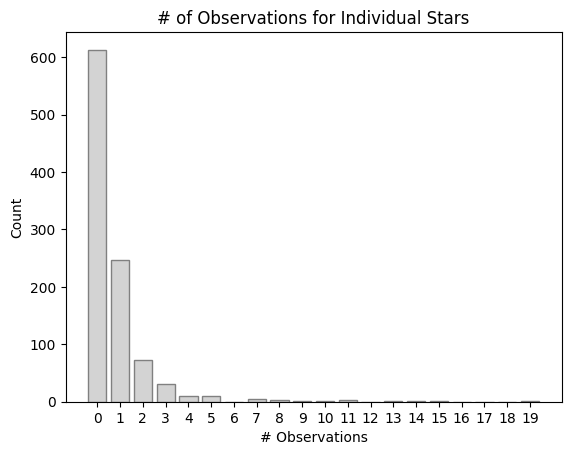

In [12]:
obs = get_paths('obs')
observations = [len(i) for i in obs]
num_observations = np.histogram(observations,bins=np.arange(0,21,1))
plt.bar(x=list(np.arange(0,20,1)),height=list(num_observations[0]), edgecolor='gray', color='lightgray')
plt.xticks(list(np.arange(0,20,1)))
plt.title("# of Observations for Individual Stars")
plt.xlabel("# Observations")
plt.ylabel("Count")

plt.show()

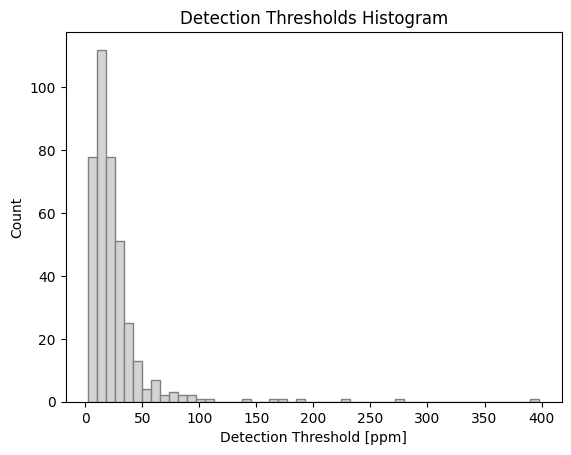

In [13]:
# plot threshold levels
thresholds = get_paths('threshold')
thresholds_list = []
for i in thresholds:
    if len(i) != 0:
        with open(i[0],'rb') as f:
            pw = pickle.load(f)
        thresholds_list.append(pw)

thresholds_list =np.array(thresholds_list)
indices = np.where(thresholds_list<500)
plt.hist(thresholds_list[indices],bins=50, edgecolor='gray', color='lightgray')
plt.xlabel("Detection Threshold [ppm]")
plt.ylabel("Count")
plt.title("Detection Thresholds Histogram")
# plt.xscale('log')
plt.show()

In [18]:
def split(perio_type,min_mass,max_mass,mass_bin):
    perios = get_paths(perio_type)
    all_star_sample['perios'] = perios
    clean_m_dwarf_sample = clean_table(all_star_sample)

    # mass_bin = .05
    mass_ranges = [np.round(i,2) for i in np.arange(min_mass,max_mass+mass_bin,mass_bin)]

    for m in range(len(mass_ranges)-1):
        subset = clean_m_dwarf_sample[(clean_m_dwarf_sample['Mass']>mass_ranges[m]) & (clean_m_dwarf_sample['Mass']<mass_ranges[m+1])]
        perios_subset =subset['perios'].array
        summed_perio = []
        for i in perios_subset:
            if len(i) != 0:
                with open(i[0],'rb') as f:
                    pw = pickle.load(f)
                summed_perio.append(np.array(pw))

        summed_perio = sum(summed_perio)
        if perio_type == 'perio':
            perio_frequency = np.arange(2, 2160,0.008)
            frequency_hz = [(i*10**6)/(24*60*60) for i in np.array(perio_frequency)]
        else:
            frequency_hz = np.arange(20, 20000,0.008)

        plt.figure(figsize=(10,5))

        plt.plot(frequency_hz[1000:-1000],summed_perio[1000:-1000],color='black',alpha=.8,label=f'{len(perios_subset)} Stars Summed')
        plt.xlabel("Frequency [uHz]")
        plt.ylabel("Power")
        plt.legend()
        if perio_type=="psd":
            plt.yscale('log')
            plt.xscale('log')
        plt.title(f"Summed Powers in Mass Range {mass_ranges[m]}-{mass_ranges[m+1]}")
        plt.show()

In [28]:
all_star_sample[870:875]

,GJ,Comp,NComp,P?,GJp,GaiaDR3,HIP,RAJ2000,DEJ2000,Epoch,...,Hmag,Ksmag,W1mag,W2mag,W3mag,W4mag,SimbadName,Mass,distance,perios
CNS5,,,,,,,,,,,,,,,,,,,,,
4403,693.0,,,0,,5918660719983560192,86990,266.633444,-57.325062,2016.0,...,6.297,6.016,,,,,HIP 86990,0.491888,5.888241,[/Users/caleb/research/Astro_98/lightkurve_dat...
4200,656.0,,,0,,5914096303621755520,83990,257.543775,-60.726153,2016.0,...,5.204,5.091,5.121,4.967,5.113,5.056,HIP 83990,0.628034,13.721186,[/Users/caleb/research/Astro_98/lightkurve_dat...
3500,12038.0,,,0,,5866128597052432128,,212.787837,-61.929942,2016.0,...,7.173,6.921,6.771,6.716,6.765,7.193,Gaia DR3 5866128597052432128,0.321693,19.580967,[/Users/caleb/research/Astro_98/lightkurve_dat...
3639,560.0,B,2,0,,5849837820492182272,71908,220.617547,-64.979229,2016.0,...,5.690,5.514,,,,,HIP 71908,0.577828,16.436555,[/Users/caleb/research/Astro_98/lightkurve_dat...
3214,3759.0,,,0,,5863130980814698112,63550,195.328004,-63.196879,2016.0,...,7.149,6.934,,,,,HIP 63550,0.319420,16.846361,[/Users/caleb/research/Astro_98/lightkurve_dat...


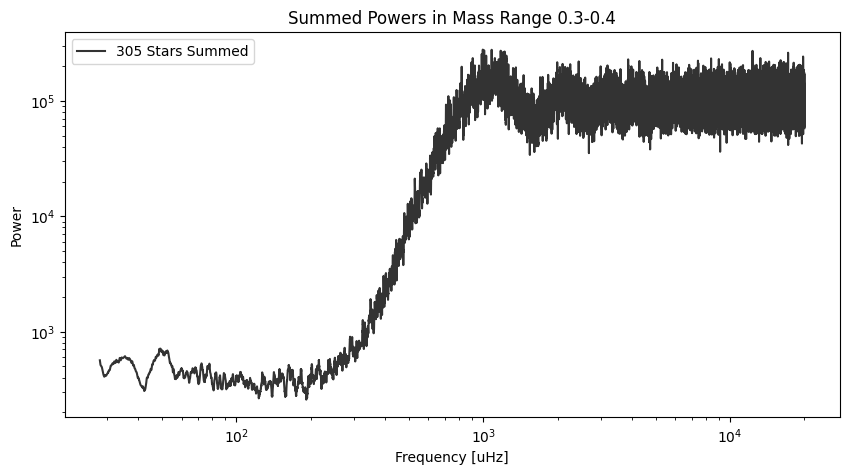

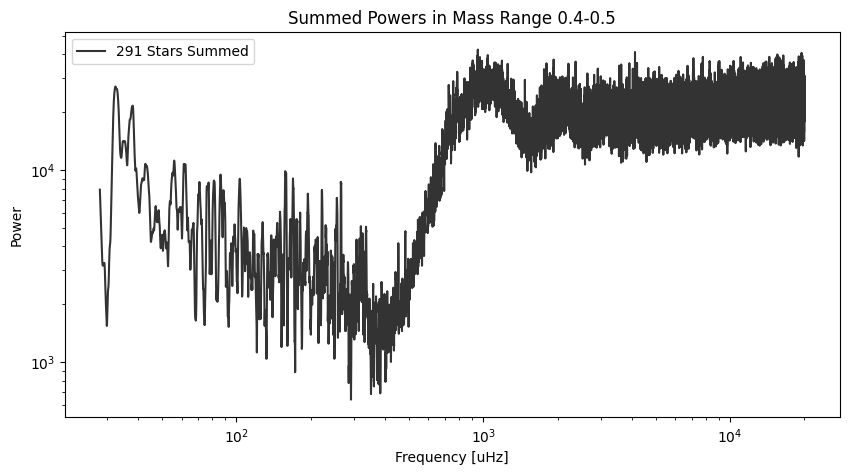

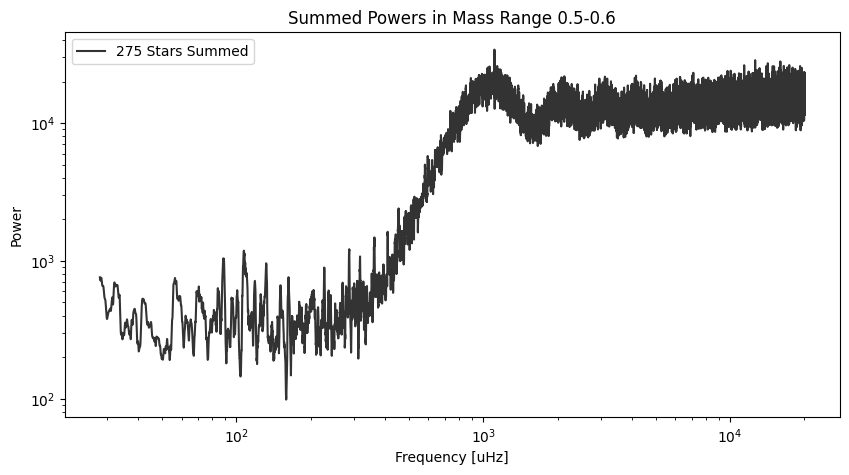

In [33]:
split('psd',.3,.6,.1)

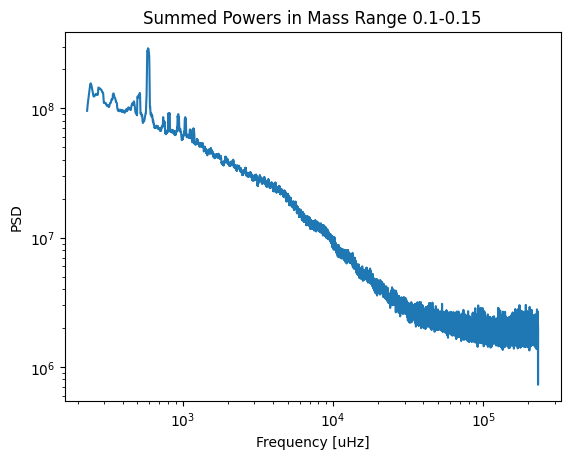

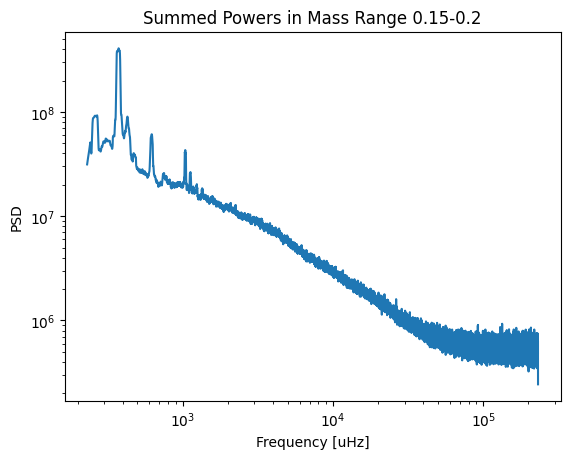

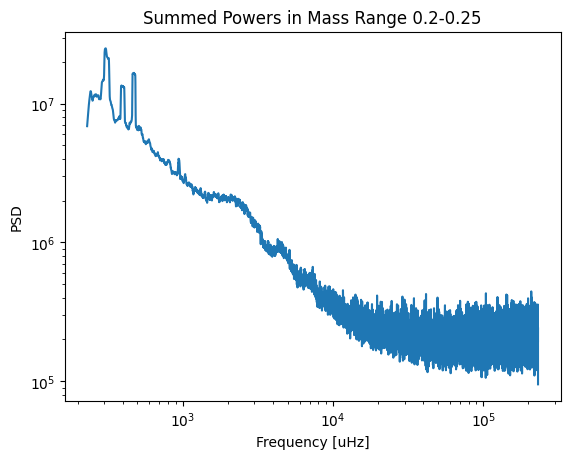

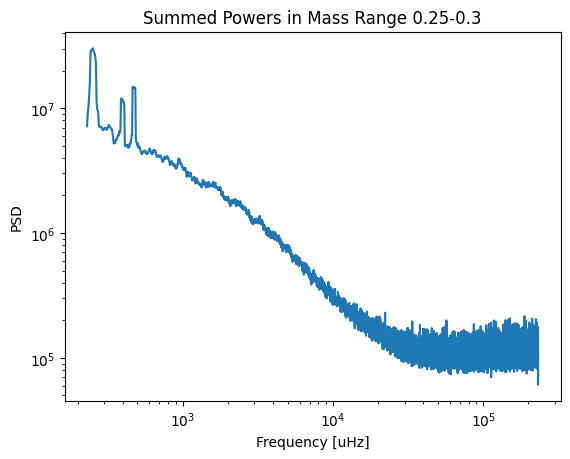

In [252]:
split('psd',.1,.3,.05)

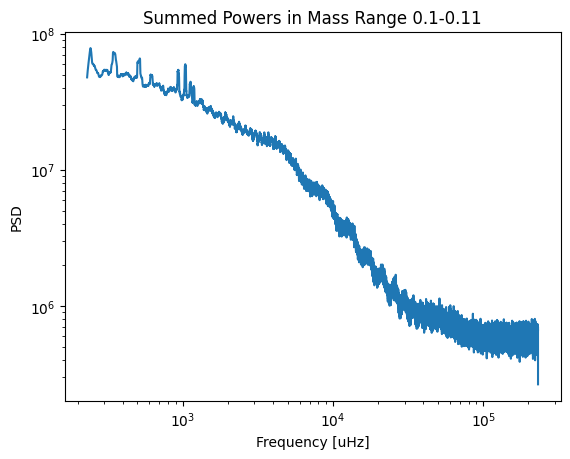

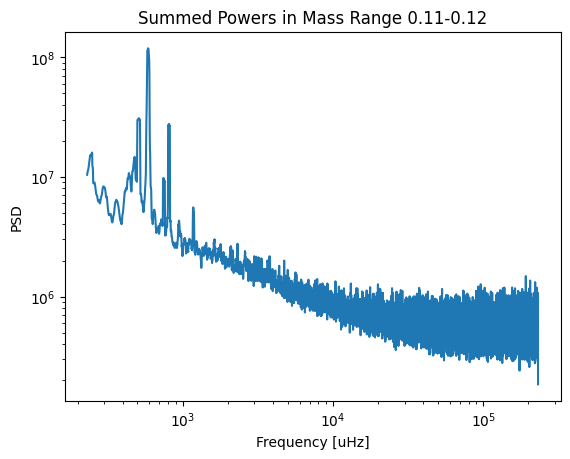

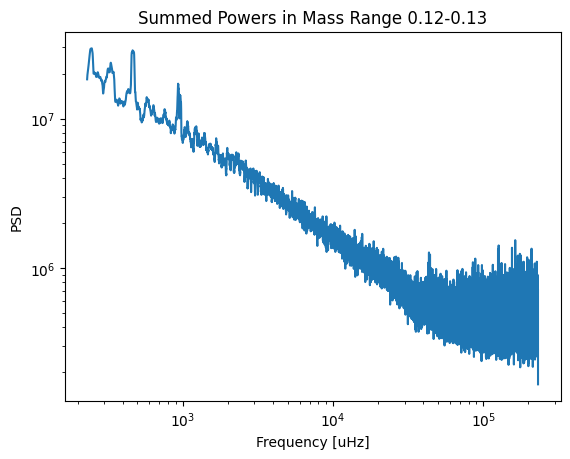

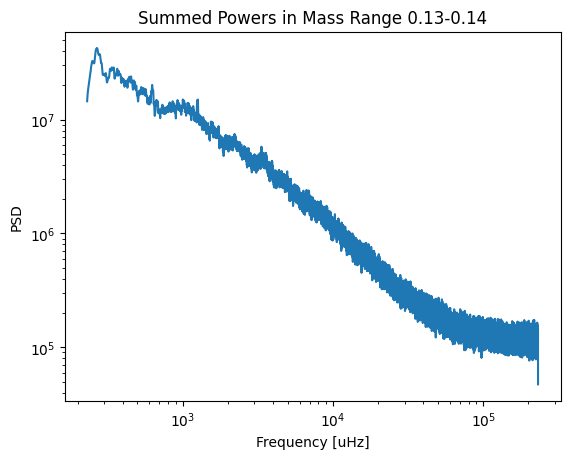

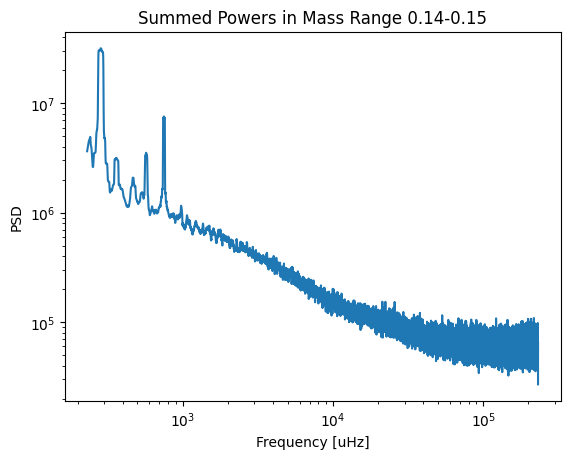

In [253]:
split('psd',.1,.15,.01)

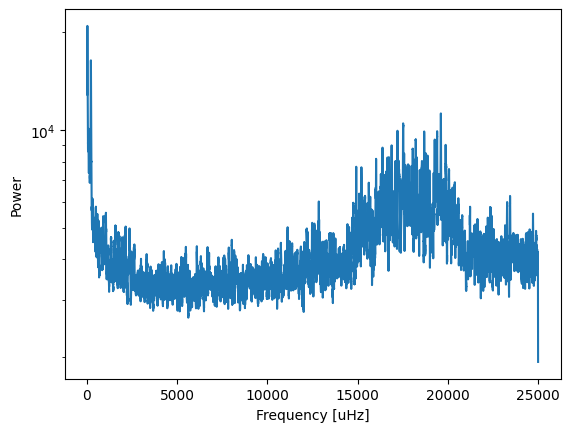

In [143]:
perio_frequency = np.arange(2, 2160,0.008)
frequency_hz = [(i*10**6)/(24*60*60) for i in np.array(perio_frequency)]
plt.plot(frequency_hz,summed_perio)
plt.xlabel("Frequency [uHz]")
plt.ylabel("Power")
plt.yscale('log')

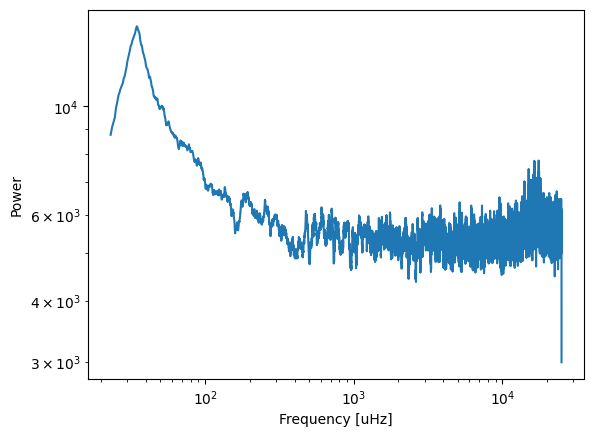

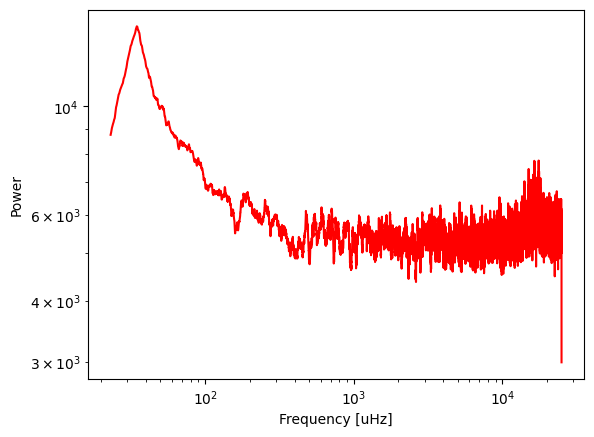

In [211]:
subset = m_dwarf_sample[(m_dwarf_sample['Mass']>.16) & (m_dwarf_sample['Mass']<.165)]

subset = m_dwarf_sample.loc[354]

summed_perio = []
for i in subset['perios']:
    if len(i) != 0:
        with open(i,'rb') as f:
            pw = pickle.load(f)
    summed_perio.append(pw)

    perio_frequency = np.arange(2, 2160,0.008)
    frequency_hz = [(i*10**6)/(24*60*60) for i in np.array(perio_frequency)]
    plt.plot(frequency_hz,pw)
    plt.xlabel("Frequency [uHz]")
    plt.ylabel("Power")
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

summed_perio = sum(summed_perio)
plt.plot(frequency_hz,summed_perio,color='red')
plt.xlabel("Frequency [uHz]")
plt.ylabel("Power")
plt.yscale('log')
plt.xscale('log')
plt.show()


(10500.0, 11500.0)

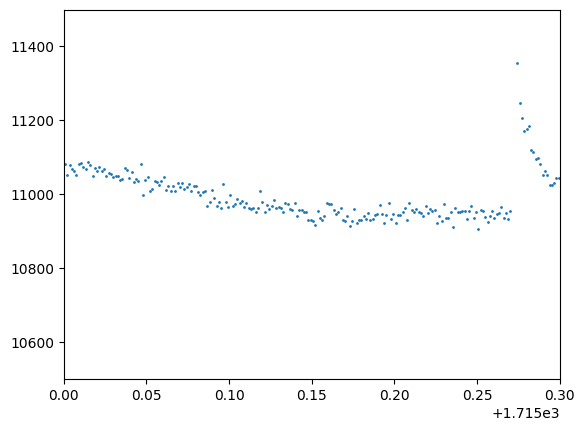

In [377]:
search_result = lk.search_lightcurve('GJ 1243',mission='TESS',exptime='short')
lc = search_result[1].download()
plt.scatter(lc.time.value,np.array(lc['flux']),s=1)
plt.xlim(1715,1715.3)
plt.ylim(10500,11500)

(10500.0, 12000.0)

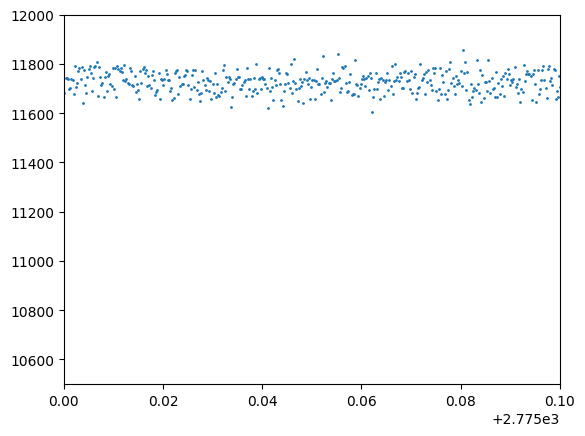

In [374]:
search_result = lk.search_lightcurve('GJ 1243',mission='TESS',exptime='fast')
lc = search_result[1].download()
plt.scatter(lc.time.value,np.array(lc['flux']),s=1)
plt.xlim(2775,2775.1)
plt.ylim(10500,12000)

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

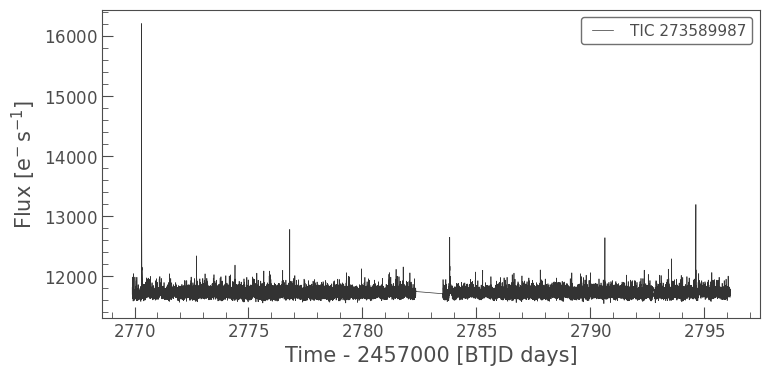

In [360]:
lc = search_result[1].download()
lc.plot()

In [384]:
search_result = lk.search_lightcurve('GJ 1243',mission='Kepler',exptime='short')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 06,2010,Kepler,60,kplr009726699,0.0
1,Kepler Quarter 06,2010,Kepler,60,kplr009726699,0.0
2,Kepler Quarter 10,2011,Kepler,60,kplr009726699,0.0
3,Kepler Quarter 10,2011,Kepler,60,kplr009726699,0.0
4,Kepler Quarter 10,2011,Kepler,60,kplr009726699,0.0
5,Kepler Quarter 12,2012,Kepler,60,kplr009726699,0.0
6,Kepler Quarter 12,2012,Kepler,60,kplr009726699,0.0
7,Kepler Quarter 12,2012,Kepler,60,kplr009726699,0.0
8,Kepler Quarter 13,2012,Kepler,60,kplr009726699,0.0


(570.0, 570.1)

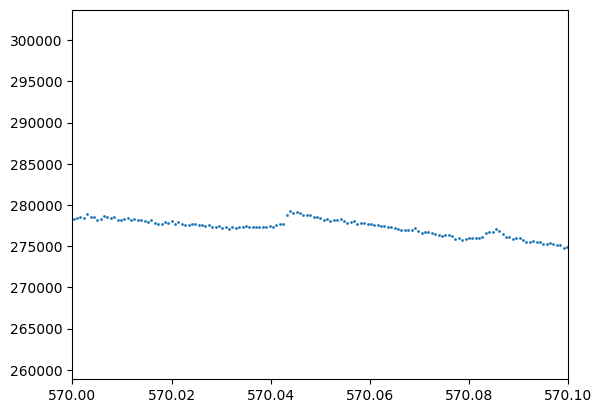

In [387]:
search_result = lk.search_lightcurve('GJ 1243',mission='Kepler',exptime='short')
lc = search_result[1].download()
plt.scatter(lc.time.value,np.array(lc['flux']),s=1)
plt.xlim(570,570.1)
# plt.ylim(27500,12000)